In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech import keys, utils
from scipy.stats import bootstrap

%matplotlib inline

In [2]:
mplego.style.use_latex_style()

In [3]:
exp = "22"
base_path = os.path.join(os.environ['HOME'], 'projects/annotator_bias_irt')
data_path = "~/data/hatespeech/unfiltered_ratings.feather"
rater_quality_path = "~/data/hatespeech/rater_quality_check.csv"
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [4]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})
# Remove all rows in which some item is missing
data = utils.filter_missing_items(data)
# Remove all rows in which the rater is not up to sufficient quality
rater_quality = pd.read_csv(rater_quality_path)
data = utils.filter_annotator_quality(data, rater_quality)
# Recode item responses
data = utils.recode_responses(
    data,
    insult={1: 0, 2: 1, 3: 2, 4: 3},
    humiliate={1: 0, 2: 0, 3: 1, 4: 2},
    status={1: 0, 2: 0, 3: 1, 4: 1},
    dehumanize={1: 0, 2: 0, 3: 1, 4: 1},
    violence={1: 0, 2: 0, 3: 1, 4: 1},
    genocide={1: 0, 2: 0, 3: 1, 4: 1},
    attack_defend={1: 0, 2: 1, 3: 2, 4: 3},
    hatespeech={1: 0, 2: 1})
# Only get comments targeting black / white people
data = data[data['target_race_white'] | data['target_race_black']]
data = data[data[keys.target_race_cols].sum(axis=1) == 1]
data['target_race'] = np.where(data['target_race_white'], 1, 2)

In [5]:
# Identify labelers who looked at both Black- and White-targeting comments
n_unique_labels = data.groupby('labeler_id')['target_race'].nunique() 
valid_labelers = n_unique_labels[n_unique_labels == 2].index

In [8]:
# Read in experiment output
out_path = os.path.join(results_path, f"exp{exp}_out.txt")
with open(out_path) as f:
    lines = f.readlines()

In [10]:
bias_lines = lines[17588:30364]
bias_cut = bias_lines[4:-7]

In [11]:
# Extract elements of each line
n_samples = len(bias_cut)
observed = np.zeros(n_samples)
expected = np.zeros(n_samples)
bias_size = np.zeros(n_samples)
t_stats = np.zeros(n_samples)
p_vals = np.zeros(n_samples)
labeler_id = np.zeros(n_samples)
measure = np.zeros(n_samples)
race = np.zeros(n_samples)

for idx, line in enumerate(bias_cut):
    processed = line.replace('|', ' ').replace('>', ' ').replace('<', ' ').split()
    observed[idx] = float(processed[0])
    expected[idx] = float(processed[1])
    bias_size[idx] = float(processed[4])
    t_stats[idx] = float(processed[6])
    p_vals[idx] = float(processed[8])
    labeler_id[idx] = int(processed[13])
    measure = float(processed[14])
    if processed[16] == 'white':
        race[idx] = 0
    elif processed[16] == 'black':
        race[idx] = 1

In [40]:
data = pd.DataFrame({
    'labeler_id': labeler_id,
    'observed': observed,
    'expected': expected,
    'bias': bias_size,
    't_statistic': t_stats,
    'p_value': p_vals,
    'measure': measure,
    'race': race}).astype({'labeler_id': int})
df = df[df['labeler_id'].isin(valid_labelers)]
df['bias_corrected'] = -df['bias']
df['bias_abs'] = df['bias'].abs()
df['target_race_name'] = np.where(df['race'] == 1, 'black', 'white')

df = df.merge(
    right=data[['labeler_id'] + keys.annotator_race_cols].drop_duplicates('labeler_id'),
    how='left',
    on='labeler_id')
df['bias_sign'] = np.where(df['bias_corrected'] < 0,
                           'negative',
                           np.where(df['bias_corrected'] > 0,
                                    'positive',
                                    'zero'))

In [43]:
bw_annotators = df[df['annotator_race_black'] | df['annotator_race_white']].copy()
target_black = bw_annotators[bw_annotators['target_race_name'] == 'black']
target_black_annotator_black = target_black[target_black['annotator_race_black']]
target_black_annotator_white = target_black[target_black['annotator_race_white']]
target_white = bw_annotators[bw_annotators['target_race_name'] == 'white']
target_white_annotator_black = target_white[target_white['annotator_race_black']]
target_white_annotator_white = target_white[target_white['annotator_race_white']]

In [44]:
bw_annotators_sig = bw_annotators[bw_annotators['p_value'] < 0.1]
target_black_sig = bw_annotators_sig[bw_annotators_sig['target_race_name'] == 'black']
target_black_annotator_black_sig = target_black_sig[target_black_sig['annotator_race_black']]
target_black_annotator_white_sig = target_black_sig[target_black_sig['annotator_race_white']]
target_white_sig = bw_annotators_sig[bw_annotators_sig['target_race_name'] == 'white']
target_white_annotator_black_sig = target_white_sig[target_white_sig['annotator_race_black']]
target_white_annotator_white_sig = target_white_sig[target_white_sig['annotator_race_white']]

In [45]:
target_black_annotator_black_props = dict(target_black_annotator_black['bias_sign'].value_counts(normalize=True))
target_black_annotator_white_props = dict(target_black_annotator_white['bias_sign'].value_counts(normalize=True))
target_white_annotator_black_props = dict(target_white_annotator_black['bias_sign'].value_counts(normalize=True))
target_white_annotator_white_props = dict(target_white_annotator_white['bias_sign'].value_counts(normalize=True))

In [46]:
target_black_annotator_black_sig_props = dict(target_black_annotator_black_sig['bias_sign'].value_counts(normalize=True))
target_black_annotator_white_sig_props = dict(target_black_annotator_white_sig['bias_sign'].value_counts(normalize=True))
target_white_annotator_black_sig_props = dict(target_white_annotator_black_sig['bias_sign'].value_counts(normalize=True))
target_white_annotator_white_sig_props = dict(target_white_annotator_white_sig['bias_sign'].value_counts(normalize=True))

In [47]:
def positive(x):
    return np.mean(x > 0)

def negative(x):
    return np.mean(x < 0)

def zero(x):
    return np.mean(x == 0)

funcs = {'positive': positive, 'negative': negative, 'zero': zero}

In [48]:
target_black_annotator_black_errs = {}
for key in target_black_annotator_black_props.keys():
    target_black_annotator_black_errs[key] = bootstrap(
        [target_black_annotator_black['bias_corrected']],
        funcs[key],
        method='basic',
        vectorized=False).standard_error
    
target_black_annotator_white_errs = {}
for key in target_black_annotator_white_props.keys():
    target_black_annotator_white_errs[key] = bootstrap(
        [target_black_annotator_white['bias_corrected']],
        funcs[key],
        method='basic',
        vectorized=False).standard_error
    
target_white_annotator_black_errs = {}
for key in target_white_annotator_black_props.keys():
    target_white_annotator_black_errs[key] = bootstrap(
        [target_white_annotator_black['bias_corrected']],
        funcs[key],
        method='basic',
        vectorized=False).standard_error
    
target_white_annotator_white_errs = {}
for key in target_white_annotator_white_props.keys():
    target_white_annotator_white_errs[key] = bootstrap(
        [target_white_annotator_white['bias_corrected']],
        funcs[key],
        method='basic',
        vectorized=False).standard_error

In [49]:
target_black_annotator_black_sig_errs = {}
for key in target_black_annotator_black_sig_props.keys():
    target_black_annotator_black_sig_errs[key] = bootstrap(
        [target_black_annotator_black_sig['bias_corrected']],
        funcs[key],
        method='basic',
        vectorized=False).standard_error
    
target_black_annotator_white_sig_errs = {}
for key in target_black_annotator_white_sig_props.keys():
    target_black_annotator_white_sig_errs[key] = bootstrap(
        [target_black_annotator_white_sig['bias_corrected']],
        funcs[key],
        method='basic',
        vectorized=False).standard_error
    
target_white_annotator_black_sig_errs = {}
for key in target_white_annotator_black_sig_props.keys():
    target_white_annotator_black_sig_errs[key] = bootstrap(
        [target_white_annotator_black_sig['bias_corrected']],
        funcs[key],
        method='basic',
        vectorized=False).standard_error
    
target_white_annotator_white_sig_errs = {}
for key in target_white_annotator_white_sig_props.keys():
    target_white_annotator_white_sig_errs[key] = bootstrap(
        [target_white_annotator_white_sig['bias_corrected']],
        funcs[key],
        method='basic',
        vectorized=False).standard_error

array([<AxesSubplot:title={'center':'\\textbf{Black-Targeting Speech}'}, ylabel='\\textbf{\\% Annotators}'>,
       <AxesSubplot:title={'center':'\\textbf{White-Targeting Speech}'}, ylabel='\\textbf{\\% Annotators}'>,
       <AxesSubplot:xlabel='\\textbf{p-value}', ylabel='\\textbf{Frequency}'>,
       <AxesSubplot:title={'center':'\\textbf{Black-Targeting Speech}\n\\textbf{(Significant)}'}, ylabel='\\textbf{\\% Annotators}'>,
       <AxesSubplot:title={'center':'\\textbf{White-Targeting Speech}\n\\textbf{(Significant)}'}, ylabel='\\textbf{\\% Annotators}'>],
      dtype=object)

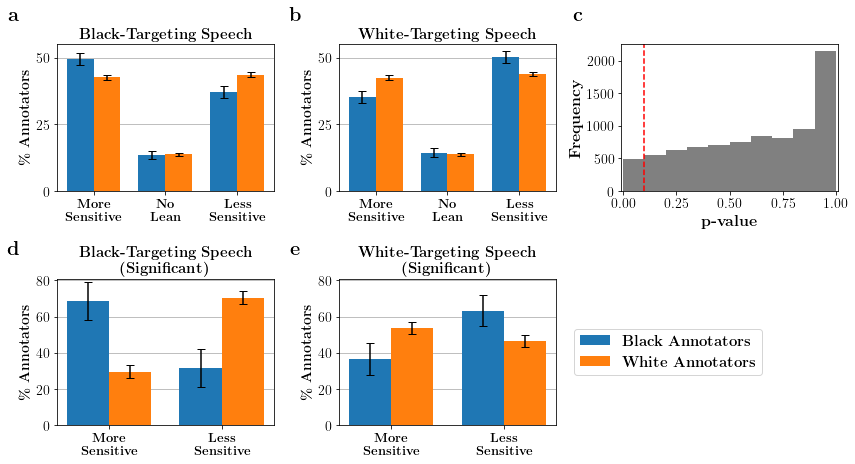

In [50]:
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
plt.subplots_adjust(hspace=0.6, wspace=0.3)

"""
Figure 4
"""
error_capsize = 4


"""
Figure 4a-b
"""
width = 0.75

axes[0, 0].bar(
    x=2 * np.arange(3) - width / 2,
    height=[100 *target_black_annotator_black_props['negative'],
            100 * target_black_annotator_black_props['zero'],
            100 * target_black_annotator_black_props['positive']],
    width=width,
    yerr=[100 * target_black_annotator_black_errs['negative'],
          100 * target_black_annotator_black_errs['zero'],
          100 * target_black_annotator_black_errs['positive']],
    color='C0',
    capsize=error_capsize)
axes[0, 0].bar(
    x=2 * np.arange(3) + width / 2,
    height=[100 * target_black_annotator_white_props['negative'],
            100 * target_black_annotator_white_props['zero'],
            100 * target_black_annotator_white_props['positive']],
    width=width,
    color='C1',
    yerr=[100 * target_black_annotator_white_errs['negative'],
          100 * target_black_annotator_white_errs['zero'],
          100 * target_black_annotator_white_errs['positive']],
    capsize=error_capsize)
axes[0, 0].set_ylim([0, 55])
axes[0, 0].set_yticks([0, 25, 50])


axes[0, 1].bar(
    x=2 * np.arange(3) - width / 2,
    height=[100 * target_white_annotator_black_props['negative'],
            100 * target_white_annotator_black_props['zero'],
            100 * target_white_annotator_black_props['positive']],
    yerr=[100 * target_white_annotator_black_errs['negative'],
          100 * target_white_annotator_black_errs['zero'],
          100 * target_white_annotator_black_errs['positive']],
    width=width,
    color='C0',
    capsize=error_capsize)
axes[0, 1].bar(
    x=2 * np.arange(3) + width / 2,
    height=[100 * target_white_annotator_white_props['negative'],
            100 * target_white_annotator_white_props['zero'],
            100 * target_white_annotator_white_props['positive']],
    yerr=[100 * target_white_annotator_white_errs['negative'],
          100 * target_white_annotator_white_errs['zero'],
          100 * target_white_annotator_white_errs['positive']],
    width=width,
    color='C1',
    capsize=error_capsize)

axes[0, 0].set_ylim([0, 55])
axes[0, 0].set_yticks([0, 25, 50])
axes[0, 1].set_ylim([0, 55])
axes[0, 1].set_yticks([0, 25, 50])


"""
Figure 4c
"""
axes[0, 2].hist(
    df['p_value'],
    bins=np.linspace(0, 1, 11),
    color='gray')
axes[0, 2].tick_params(labelsize=14)
axes[0, 2].set_xlim([-0.01, 1.01])
axes[0, 2].set_xlabel(mplego.labels.bold_text('p-value'), fontsize=16)
axes[0, 2].axvline(0.1, color='red', linestyle='--')
axes[0, 2].set_ylabel(mplego.labels.bold_text('Frequency'), fontsize=16)

"""
Figure 4d-e
"""
axes[1, 0].bar(
    x=2 * np.arange(2) - width / 2,
    height=[100 * target_black_annotator_black_sig_props['negative'],
            100 * target_black_annotator_black_sig_props['positive']],
    width=width,
    yerr=[100 * target_black_annotator_black_sig_errs['negative'],
          100 * target_black_annotator_black_sig_errs['positive']],
    color='C0',
    capsize=error_capsize)
axes[1, 0].bar(
    x=2 * np.arange(2) + width / 2,
    height=[100 * target_black_annotator_white_sig_props['negative'],
            100 * target_black_annotator_white_sig_props['positive']],
    width=width,
    color='C1',
    yerr=[100 * target_black_annotator_white_sig_errs['negative'],
          100 * target_black_annotator_white_sig_errs['positive']],
    capsize=error_capsize)

axes[1, 1].bar(
    x=2 * np.arange(2) - width / 2,
    height=[100 * target_white_annotator_black_sig_props['negative'],
            100 * target_white_annotator_black_sig_props['positive']],
    width=width,
    yerr=[100 * target_white_annotator_black_sig_errs['negative'],
          100 * target_white_annotator_black_sig_errs['positive']],
    color='C0',
    capsize=error_capsize)
axes[1, 1].bar(
    x=2 * np.arange(2) + width / 2,
    height=[100 * target_white_annotator_white_sig_props['negative'],
            100 * target_white_annotator_white_sig_props['positive']],
    width=width,
    color='C1',
    yerr=[100 * target_white_annotator_white_sig_errs['negative'],
          100 * target_white_annotator_white_sig_errs['positive']],
    capsize=error_capsize)


"""
Legend
"""
axes[1, 1].bar(x=0, height=0, color='C0', label=mplego.labels.bold_text('Black Annotators'))
axes[1, 1].bar(x=0, height=0, color='C1', label=mplego.labels.bold_text('White Annotators'))
axes[1, 1].legend(bbox_to_anchor=(1.05, 0.5),
                  loc='center left',
                  prop={'size': 15})

for ax in axes[:2, :2].ravel():
    ax.grid('on', axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(mplego.labels.bold_text('\% Annotators'), fontsize=14)
    ax.tick_params(labelsize=14)

for ax in axes[0, :2]:
    ax.set_xticks([0, 2, 4])
    ax.set_xticklabels(mplego.labels.bold_text(['More\nSensitive', 'No\nLean', 'Less\nSensitive']),
                       fontsize=13)
    
for ax in axes[1, :2]:
    ax.set_xticks([0, 2])
    ax.set_ylim([0, 81])
    ax.set_xticklabels(mplego.labels.bold_text(['More\nSensitive', 'Less\nSensitive']),
                       fontsize=13)
    
    
axes[0, 0].set_title(mplego.labels.bold_text('Black-Targeting Speech'), fontsize=15)
axes[0, 1].set_title(mplego.labels.bold_text('White-Targeting Speech'), fontsize=15)
axes[1, 0].set_title(mplego.labels.bold_text('Black-Targeting Speech\n(Significant)'), fontsize=15)
axes[1, 1].set_title(mplego.labels.bold_text('White-Targeting Speech\n(Significant)'), fontsize=15)


axes[-1, -1].axis('off')

mplego.labels.apply_subplot_labels(axes.ravel()[:5], x=-0.2, y=1.2, bold=True, size=20)

#plt.savefig('figure4.pdf', bbox_inches='tight')